# Complete Heuristic 

## Libraries

In [7]:
# Libs
import random
import numpy as np
import random
import math
import networkx as nx
import re

# Our libs
import TRAIN_heuristic_plotFunctions
import TRAIN_heuristic_randomSolution
import TRAIN_heuristic_manageData
import TRAIN_heuristic_objectiveFunction
import TRAIN_heuristic_localSearchOperators
import TRAIN_heuristic_LS_LTL_SL
import TRAIN_heuristic_perturb

## Extract data

In [8]:
# EXTRACT DATA

filename = "TL8_LTL8_L_D.txt"
num_trailers = 53

# Parameters
num_costumers, num_terminals, Q, c1 , c2 , r, nodes, q, LTL_orders, LTL_pattern = TRAIN_heuristic_manageData.extract_data(    filename = filename     )
num_nodes = num_terminals + num_costumers
nodes_matrix = nodes

nodes_indices, terminals_indices, costumers_indices, trailer_indices = TRAIN_heuristic_manageData.get_arrays_of_indices(
    num_nodes = num_nodes,
    num_terminals = num_terminals,
    num_costumers = num_costumers, 
    num_trailers = num_trailers
    )

# Show 
#print("num_costumers =", num_costumers)
#print("num_terminals =", num_terminals)
#print("Q =", Q)
#print("r =", r)
#print("nodes:")
#for row in nodes:
#    print(row)
#print("q:", q)
print(LTL_orders)
print(LTL_pattern)

[[28 12 24]
 [12 42 24]
 [ 8  7 24]
 [17  9 24]
 [34 47 24]
 [42 13 24]
 [16 42 24]
 [ 0 29 24]
 [46 30  4]
 [38 18  4]
 [10 20  4]
 [ 4 45  6]
 [ 3 26  6]
 [38 44  4]
 [20 28  4]
 [48 35  4]]
[[31  1]
 [35 28]
 [17 44]]
8
L


#### Local search function 1: only local search operators
* Build a random solution $s_{best}$
* Repeat $t$ times
    * Choose a local search $ls$ randomly
    * Apply $ls$ on the current best solution $s_{best}$, finding $s'$
    * Check if $s'$ is better then $s_{best}$ (in case upload) 
* Return $s_{best}$

In [9]:
def local_search( num_nodes,num_terminals,num_costumers,num_trailers,nodes_matrix,c1,c2,
                  x,w,z,y,costumers_indices,terminals_indices,trailer_indices,r, Q, iteration_number = 10
                  ):
    
    f = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers,
                                                              num_trailers = num_trailers, nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x, w = w )
    
    while iteration_number > 0:
        iteration_number -= 1
        l = random.choice([TRAIN_heuristic_localSearchOperators.TL_relocate, TRAIN_heuristic_localSearchOperators.exchange, TRAIN_heuristic_LS_LTL_SL.SL_LTL_change_lc])
  
        y_temp,z_temp,x_temp,w_temp = l( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers, num_trailers = num_trailers,
                                         nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x, w = w, z = z, y = y, costumers_indices = costumers_indices,
                                         terminals_indices = terminals_indices, trailer_indices = trailer_indices, r = r, Q = Q)
        
        new_f = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers, num_trailers = num_trailers, 
                                                                      nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x_temp, w = w_temp )
        
        if new_f < f:
            f = new_f
            x = np.copy(x_temp)
            y = np.copy(y_temp)
            z = np.copy(z_temp)
            w = np.copy(w_temp)
    
    return y,z,x,w

#### Local search function 2 : exactly paper shape
* Build a random solution $s_{best}$
* Define the list of local search $\text{list}_{\text{local search}} = [\text{ls}_0,\text{ls}_1,\text{ls}_2]$
* Repeat $t$ times
    * Repeat until $\text{list}_{\text{local search}}$ is empty
        * Choose a local search $ls$ randomly from $\text{list}_{\text{local search}}$
        * Apply $ls$ on the current best solution $s_{best}$, finding $s'$
        * Check if $s'$ is better then $s_{best}$ 
            * If yes, update $s_{best}$ AND  $\text{list}_{\text{local search}} = [\text{ls}_0,\text{ls}_1,\text{ls}_2]$
            * If not, remove $ls$ from $\text{list}_{\text{local search}}$
* Return $s_{best}$

In [10]:
def multi_iterated_local_search( num_nodes,num_terminals,num_costumers,num_trailers,nodes_matrix,c1,c2,
                                x,w,z,y,costumers_indices,terminals_indices,trailer_indices,r, Q, iteration_number = 10
                                ):
    
    f = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers,
                                                              num_trailers = num_trailers, nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x, w = w )
    you_can_go_out = False

    while iteration_number > 0:
        iteration_number -= 1
        list_of_localSearch = list([TRAIN_heuristic_localSearchOperators.TL_relocate, TRAIN_heuristic_localSearchOperators.exchange, TRAIN_heuristic_LS_LTL_SL.SL_LTL_change_lc])

        while you_can_go_out == False:
            
            ls = random.choice(list_of_localSearch)
    
            y_temp,z_temp,x_temp,w_temp = ls( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers, num_trailers = num_trailers,
                                             nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x, w = w, z = z, y = y, costumers_indices = costumers_indices,
                                             terminals_indices = terminals_indices, trailer_indices = trailer_indices, r = r, Q = Q)

            new_f = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, num_terminals = num_terminals, num_costumers = num_costumers, num_trailers = num_trailers, 
                                                                          nodes_matrix = nodes_matrix, c1 = c1, c2 = c2, x = x_temp, w = w_temp )

            if new_f < f:
                f = new_f
                x = np.copy(x_temp)
                y = np.copy(y_temp)
                z = np.copy(z_temp)
                w = np.copy(w_temp)

                list_of_localSearch = list([TRAIN_heuristic_localSearchOperators.TL_relocate, TRAIN_heuristic_localSearchOperators.exchange, TRAIN_heuristic_LS_LTL_SL.SL_LTL_change_lc])

            else:
                list_of_localSearch.remove(ls)
                if len(list_of_localSearch) == 0: you_can_go_out = True
    
    return y,z,x,w

### GLOBAL HEURISTIC FUNCTION:

In [11]:
def HEURISTIC(  restart_max, h_iter_max,
                num_nodes, 
                num_terminals, 
                num_costumers, 
                num_trailers, 
                nodes_matrix,
                c1, c2, 
                costumers_indices, 
                terminals_indices,
                trailer_indices, 
                r, Q, 
                LTL_orders, LTL_pattern):
    
    iteration = 0
    while (iteration < restart_max):
        y_0, z_0, x_0, w_0 = TRAIN_heuristic_randomSolution.random_solution(nodes_matrix = nodes_matrix, 
                                                                    num_terminals = num_terminals, 
                                                                    num_trailers = num_trailers,
                                                                    trailer_capacity = Q, 
                                                                    number_of_experienced_drivers = r)

        f_0 = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, 
                                                                    num_terminals = num_terminals, 
                                                                    num_costumers = num_costumers, 
                                                                    num_trailers = num_trailers, 
                                                                    nodes_matrix = nodes_matrix, 
                                                                    c1 = c1, c2 = c2, x = x_0, w = w_0 )
        print(f_0)

        y, z, x, w = TRAIN_heuristic_localSearchOperators.multi_iterated_local_search(  num_nodes = num_nodes, 
                                                                                        num_terminals = num_terminals, 
                                                                                        num_costumers = num_costumers, 
                                                                                        num_trailers = num_trailers, 
                                                                                        nodes_matrix = nodes_matrix,
                                                                                        c1 = c1, c2 = c2, x = x_0, w = w_0, z = z_0, y = y_0, 
                                                                                        costumers_indices = costumers_indices, 
                                                                                        terminals_indices = terminals_indices,
                                                                                        trailer_indices = trailer_indices, 
                                                                                        r = r, Q = Q, iteration_number = 50)
        
        f = TRAIN_heuristic_objectiveFunction.objective_function(   num_nodes = num_nodes, 
                                                                    num_terminals = num_terminals, 
                                                                    num_costumers = num_costumers, 
                                                                    num_trailers = num_trailers, 
                                                                    nodes_matrix = nodes_matrix, 
                                                                    c1 = c1, c2 = c2, x = x, w = w )
        print(f)
        
        h_iter = 0
        while (h_iter < h_iter_max):
            y_1, z_1, x_1, w_1 = TRAIN_heuristic_perturb.perturb(   num_nodes = num_nodes, 
                                                            num_terminals = num_terminals, 
                                                            num_costumers = num_costumers, 
                                                            num_trailers = num_trailers, 
                                                            nodes_matrix = nodes_matrix,
                                                            x = x, w = w, z = z, y = y, 
                                                            costumers_indices = costumers_indices, 
                                                            terminals_indices = terminals_indices,
                                                            trailer_indices = trailer_indices, 
                                                            LTL_orders = LTL_orders)
            
            y_2, z_2, x_2, w_2 = TRAIN_heuristic_localSearchOperators.multi_iterated_local_search(  num_nodes = num_nodes, 
                                                                                                    num_terminals = num_terminals, 
                                                                                                    num_costumers = num_costumers, 
                                                                                                    num_trailers = num_trailers, 
                                                                                                    nodes_matrix = nodes_matrix,
                                                                                                    c1 = c1, c2 = c2, x = x_1, w = w_1, z = z_1, y = y_1, 
                                                                                                    costumers_indices = costumers_indices, 
                                                                                                    terminals_indices = terminals_indices,
                                                                                                    trailer_indices = trailer_indices, 
                                                                                                    r = r, Q = Q, iteration_number = 50)
            
            f_2 = TRAIN_heuristic_objectiveFunction.objective_function( num_nodes = num_nodes, 
                                                                    num_terminals = num_terminals, 
                                                                    num_costumers = num_costumers, 
                                                                    num_trailers = num_trailers, 
                                                                    nodes_matrix = nodes_matrix, 
                                                                    c1 = c1, c2 = c2, x = x_2, w = w_2 )
            
            if f_2 < f:
                y = np.copy(y_2)
                z = np.copy(z_2)
                x = np.copy(x_2)
                w = np.copy(w_2)
                f = f_2
                h_iter = 0
            else:
                h_iter += 1

            
        iteration += 1
    
    TRAIN_heuristic_plotFunctions.plot_solution(nodes_matrix = nodes_matrix, 
                                                num_terminals = num_terminals, 
                                                num_trailers = num_trailers, 
                                                w = w_0, x = x_0 )
    print(f)
    print("Improvement of", round((f_0 - f)))
    print("Relative improvement of", round(((f_0 - f)/f_0)*100),"%")
    return y, z, x, w, f

944.23
593.7


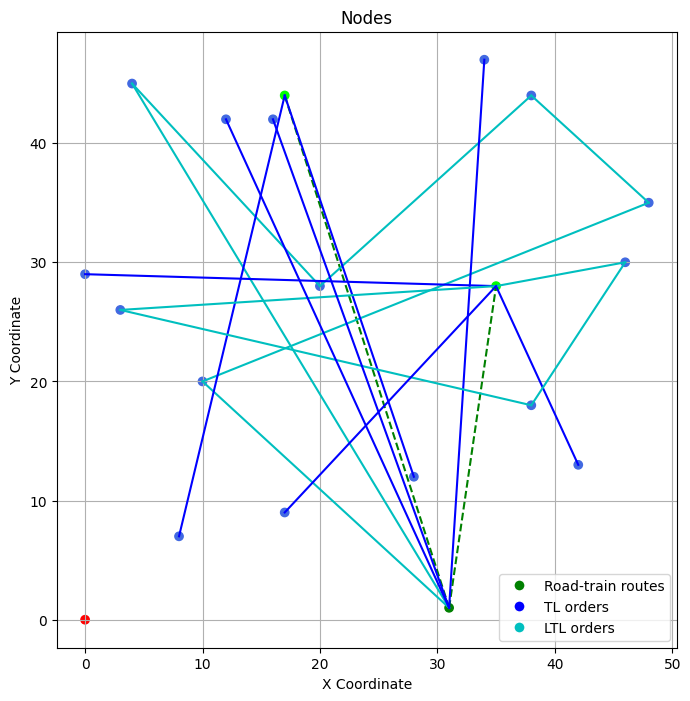

593.7
Improvement of 351
Relative improvement of 37 %


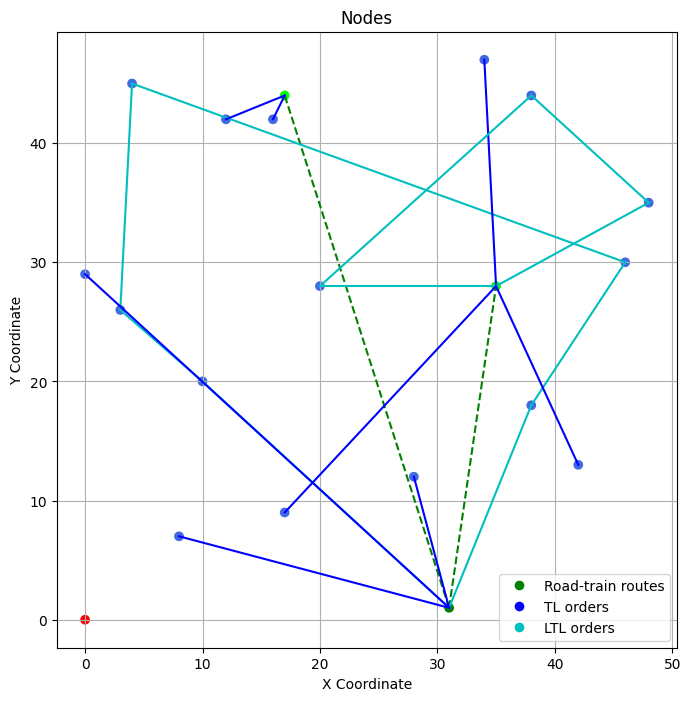

In [12]:
# Application

y, z, x, w, f = HEURISTIC(  restart_max=1, h_iter_max=5,
                            num_nodes = num_nodes, 
                            num_terminals = num_terminals, 
                            num_costumers = num_costumers, 
                            num_trailers = num_trailers, 
                            nodes_matrix = nodes_matrix,
                            c1 = c1, c2 = c2, 
                            costumers_indices = costumers_indices, 
                            terminals_indices = terminals_indices,
                            trailer_indices = trailer_indices, 
                            r = r, Q = Q, 
                            LTL_orders = LTL_orders, LTL_pattern = LTL_pattern)

# plot solution after local search
TRAIN_heuristic_plotFunctions.plot_solution(  nodes_matrix = nodes_matrix, num_terminals = num_terminals, num_trailers = num_trailers, w = w, x = x   )